
# Combined PJM Energy, Temperature, and Gas Analysis

This notebook blends the PJM net-load/price analysis (`energy.ipynb`), temperature diagnostics (`temp_analysis.ipynb`), and Henry Hub fuel study (`naturalGas.ipynb`). The objective is to explore how load, weather, and fuel jointly drive PJM day-ahead prices and to build predictive models (linear and XGBoost) that capture those relationships.



## Objectives
- Assemble an hourly dataset of PJM price, net load, PJM-wide temperature, and Henry Hub spot gas (plus volatility).
- Visualize interactions between the drivers and PJM price to understand joint behaviour.
- Quantify gas volatility thresholds where price residuals deviate from the net-load baseline.
- Train baseline linear regressions and XGBoost regressors/classifiers to forecast prices and flag spikes/falls.


In [109]:

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, r2_score, classification_report,
                             precision_recall_fscore_support, roc_auc_score, mean_absolute_error)

try:
    import xgboost as xgb
except ImportError:
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgboost'])
    import xgboost as xgb

plt.style.use('default')
plt.rcParams.update({'figure.dpi': 120})
sns.set_context('talk', font_scale=0.8)

DATA_DIR = Path('data')
OUTPUT_DIR = Path('output_data')
PLOTS_DIR = Path('plots')
CSV_PLOTS_DIR = Path('csv_plots')

for folder in (OUTPUT_DIR, PLOTS_DIR, CSV_PLOTS_DIR):
    folder.mkdir(parents=True, exist_ok=True)

SEASON_MAP = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

def export_plot_data(df: pd.DataFrame, filename: str) -> Path:
    path = CSV_PLOTS_DIR / filename
    df.to_csv(path, index=False)
    return path


## Load and merge PJM + temperature + gas data

In [110]:

price_path = DATA_DIR / 'day_ahead_energy_price.csv'
df_price = pd.read_csv(price_path)
df_price['datetime_beginning_ept'] = pd.to_datetime(
    df_price['datetime_beginning_ept'],
    format='%m/%d/%Y %I:%M:%S %p'
)
df_price = df_price[df_price['pnode_name'] == 'PJM-RTO'][[
    'datetime_beginning_ept',
    'system_energy_price_da'
]].rename(columns={'system_energy_price_da': 'price'})

net_path = OUTPUT_DIR / 'net_load_data_ept.csv'
df_net = pd.read_csv(net_path, parse_dates=['forecast_hour_beginning_ept'])
df_net = df_net[df_net['forecast_area'] == 'RTO']
df_net = df_net.groupby('forecast_hour_beginning_ept', as_index=False)['net_load_mw'].mean()
df_net = df_net.rename(columns={'forecast_hour_beginning_ept': 'datetime_beginning_ept'})

temp_path = OUTPUT_DIR / 'pjm_temperature_hourly.csv'
df_temp = pd.read_csv(temp_path, parse_dates=['datetime_beginning_ept'])

gas_path = DATA_DIR / 'daily_henryhub_naturalgasspotprice.csv'
df_gas = pd.read_csv(gas_path, encoding='utf-8-sig')
df_gas = df_gas.rename(columns={'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'gas_price'})
df_gas['date'] = pd.to_datetime(df_gas['Date'])
df_gas['gas_price'] = pd.to_numeric(df_gas['gas_price'], errors='coerce')
for win in (7, 14, 30):
    df_gas[f'gas_vol_{win}'] = df_gas['gas_price'].rolling(win).std()

combined = (
    df_price.merge(df_net, on='datetime_beginning_ept', how='inner')
             .merge(df_temp[['datetime_beginning_ept', 'avg_temp_f', 'cdd', 'hdd']], on='datetime_beginning_ept', how='left')
)
combined['date'] = combined['datetime_beginning_ept'].dt.floor('D')
combined = combined.merge(df_gas[['date', 'gas_price', 'gas_vol_7', 'gas_vol_14', 'gas_vol_30']], on='date', how='left')
combined = combined.dropna(subset=['avg_temp_f']).copy()
combined['gas_price'] = combined['gas_price'].astype(float).ffill()
combined[['gas_vol_7', 'gas_vol_14', 'gas_vol_30']] = combined[['gas_vol_7', 'gas_vol_14', 'gas_vol_30']].ffill()

combined['hour'] = combined['datetime_beginning_ept'].dt.hour
combined['weekday'] = combined['datetime_beginning_ept'].dt.day_name().str[:3]
combined['season'] = combined['datetime_beginning_ept'].dt.month.map(SEASON_MAP)

print(f"Rows in combined dataset: {len(combined):,}")
display(combined.head())


Rows in combined dataset: 6,327


/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_18833/3331736105.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_gas['date'] = pd.to_datetime(df_gas['Date'])


,datetime_beginning_ept,price,net_load_mw,avg_temp_f,cdd,hdd,date,gas_price,gas_vol_7,gas_vol_14,gas_vol_30,hour,weekday,season
7,2023-10-06 07:00:00,30.35,76261.166667,68.9,3.9,0.0,2023-10-06,3.3,0.221864,0.201216,0.177937,7,Fri,Fall
9,2023-10-06 09:00:00,30.96,80954.000000,77.0,12.0,0.0,2023-10-06,3.3,0.221864,0.201216,0.177937,9,Fri,Fall
10,2023-10-06 10:00:00,30.32,83029.500000,77.0,12.0,0.0,2023-10-06,3.3,0.221864,0.201216,0.177937,10,Fri,Fall
12,2023-10-06 12:00:00,29.35,84335.000000,77.0,12.0,0.0,2023-10-06,3.3,0.221864,0.201216,0.177937,12,Fri,Fall
14,2023-10-06 14:00:00,33.33,84096.000000,77.0,12.0,0.0,2023-10-06,3.3,0.221864,0.201216,0.177937,14,Fri,Fall


## Figure 1 – PJM price vs fundamental drivers (Oct 2023 – Oct 2024)

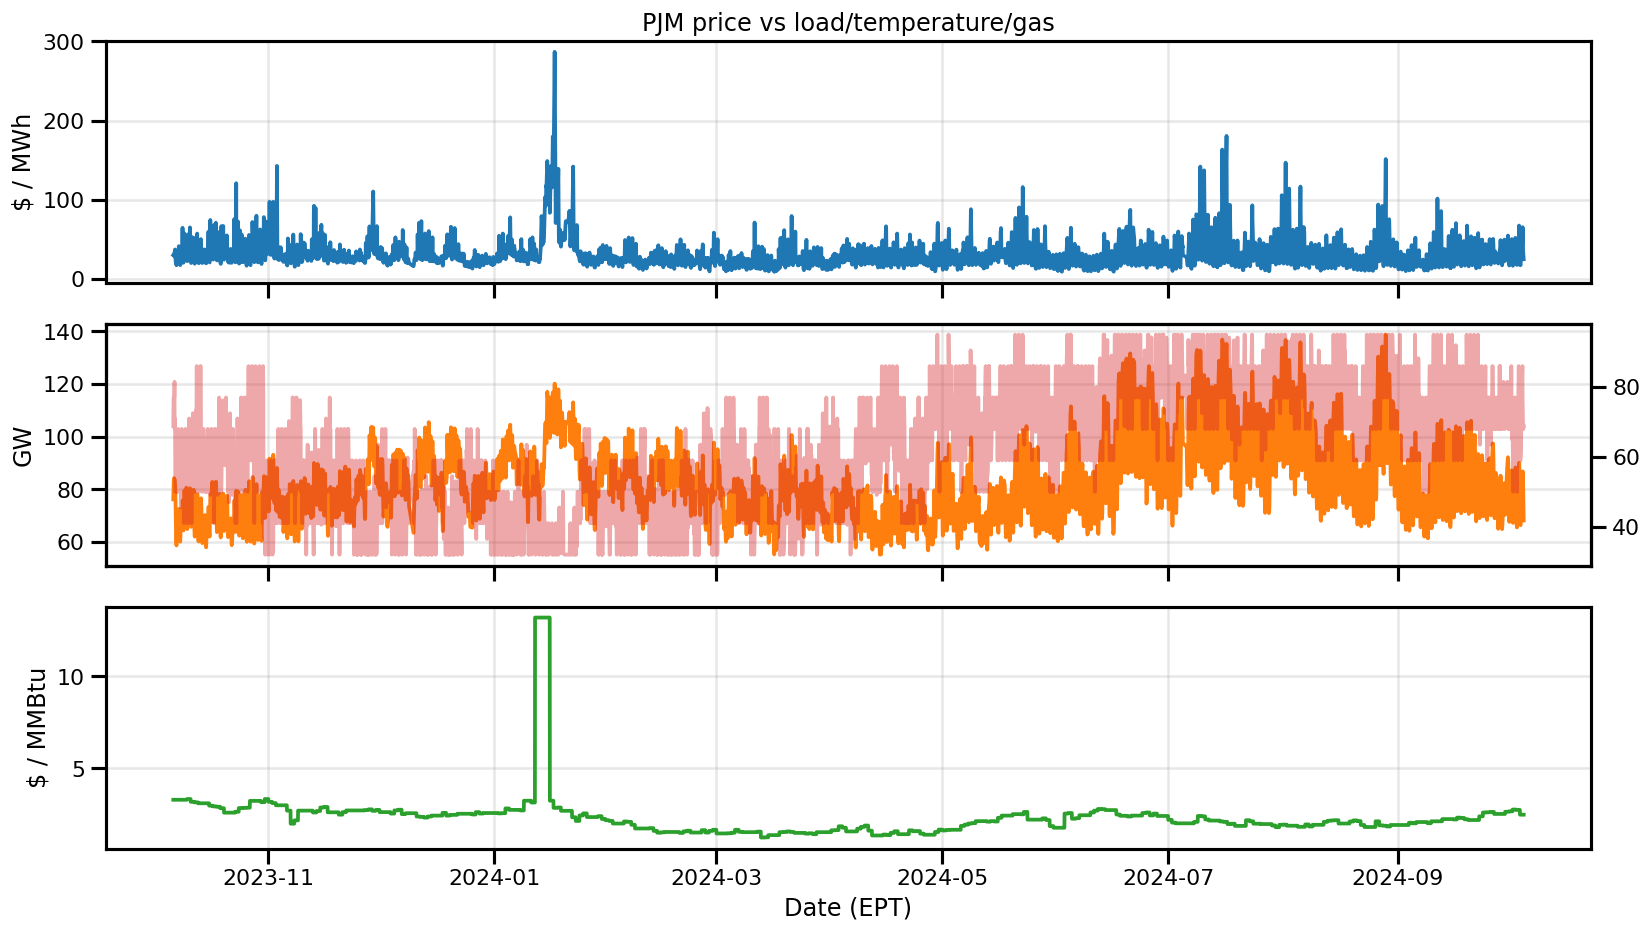

PosixPath('csv_plots/combined_timeseries_overview.csv')

In [111]:

fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
slice_df = combined.sort_values('datetime_beginning_ept')
axes[0].plot(slice_df['datetime_beginning_ept'], slice_df['price'], color='tab:blue')
axes[0].set_ylabel('$ / MWh')
axes[0].set_title('PJM price vs load/temperature/gas')
axes[0].grid(True, alpha=0.3)
axes[1].plot(slice_df['datetime_beginning_ept'], slice_df['net_load_mw'] / 1000, color='tab:orange', label='Net load (GW)')
axes[1].set_ylabel('GW')
ax2 = axes[1].twinx()
ax2.plot(slice_df['datetime_beginning_ept'], slice_df['avg_temp_f'], color='tab:red', alpha=0.4, label='Temperature (°F)')
axes[1].grid(True, alpha=0.3)
axes[2].plot(slice_df['datetime_beginning_ept'], slice_df['gas_price'], color='tab:green', label='Henry Hub')
axes[2].set_ylabel('$ / MMBtu')
axes[2].set_xlabel('Date (EPT)')
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'combined_timeseries_overview.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(slice_df[['datetime_beginning_ept', 'price', 'net_load_mw', 'avg_temp_f', 'gas_price']], 'combined_timeseries_overview.csv')



- January 2024 shows simultaneous spikes in temperature (cold), net load, gas price, and PJM price.
- Cheap-gas months keep prices anchored near $25–$35/MWh despite load oscillations.


## Figure 2 – Price vs net load (color = gas, size = temperature)

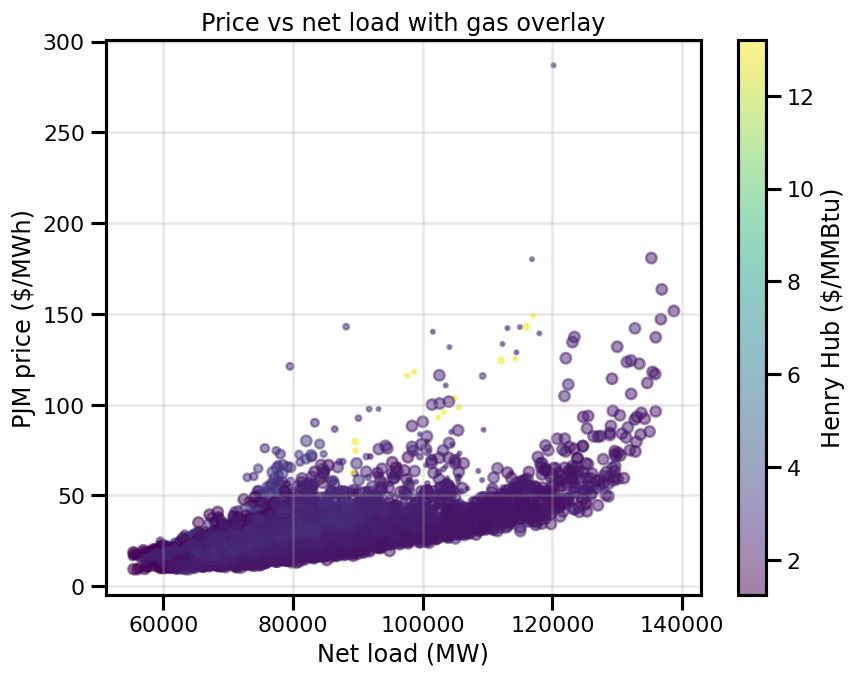

PosixPath('csv_plots/combined_scatter_netload_price.csv')

In [112]:

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    combined['net_load_mw'], combined['price'],
    c=combined['gas_price'], cmap='viridis',
    s=np.clip((combined['avg_temp_f'] - 30), 5, 40), alpha=0.5
)
ax.set_xlabel('Net load (MW)')
ax.set_ylabel('PJM price ($/MWh)')
ax.set_title('Price vs net load with gas overlay')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Henry Hub ($/MMBtu)')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'combined_scatter_netload_price.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(combined[['datetime_beginning_ept', 'net_load_mw', 'price', 'avg_temp_f', 'gas_price']], 'combined_scatter_netload_price.csv')


## Figure 3 – Price vs temperature (color = hour, size = gas)

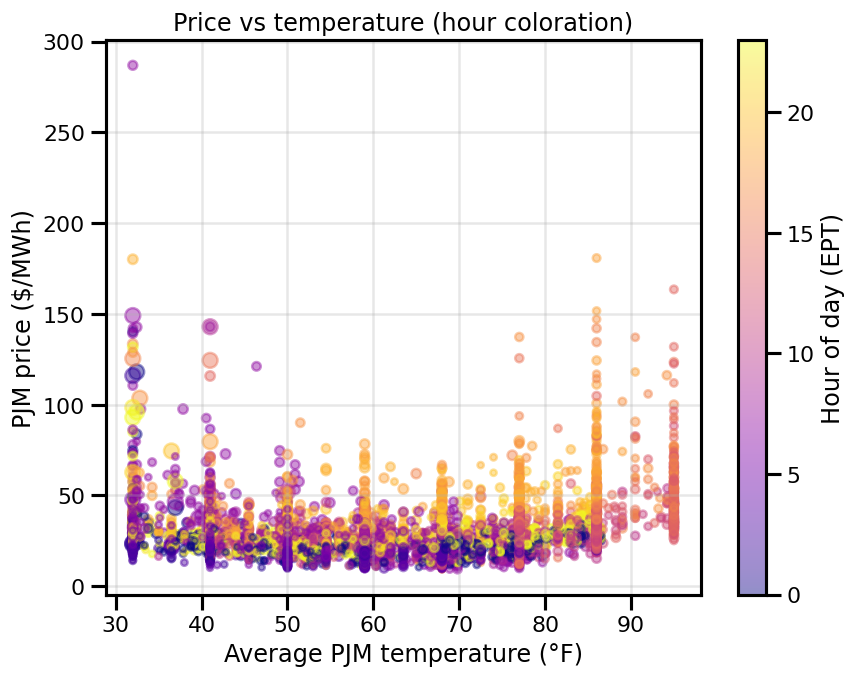

PosixPath('csv_plots/combined_scatter_temp_price.csv')

In [113]:

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(
    combined['avg_temp_f'], combined['price'],
    c=combined['hour'], cmap='plasma',
    s=np.clip(combined['gas_price'] * 10, 10, 80), alpha=0.45
)
ax.set_xlabel('Average PJM temperature (°F)')
ax.set_ylabel('PJM price ($/MWh)')
ax.set_title('Price vs temperature (hour coloration)')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Hour of day (EPT)')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'combined_scatter_temp_price.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(combined[['datetime_beginning_ept', 'avg_temp_f', 'price', 'hour', 'gas_price']], 'combined_scatter_temp_price.csv')


## Figure 4 – Rolling 30-day correlations

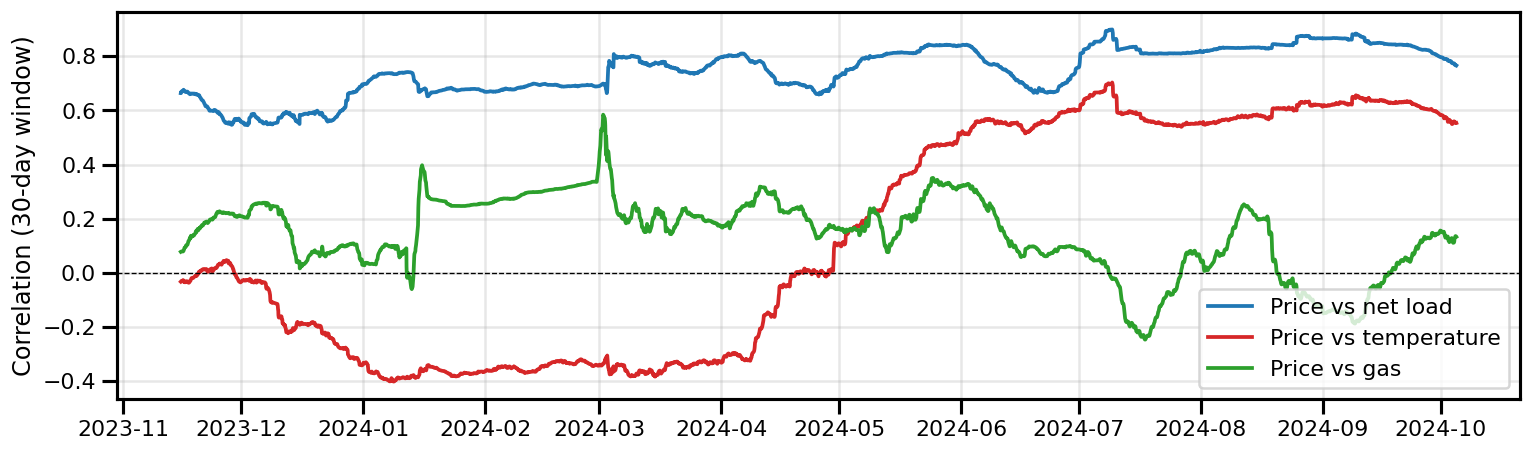

PosixPath('csv_plots/combined_rolling_correlation.csv')

In [114]:

roll_df = combined[['datetime_beginning_ept', 'price', 'net_load_mw', 'avg_temp_f', 'gas_price']].sort_values('datetime_beginning_ept')
window = 24 * 30
roll_df['corr_netload'] = roll_df['price'].rolling(window).corr(roll_df['net_load_mw'])
roll_df['corr_temp'] = roll_df['price'].rolling(window).corr(roll_df['avg_temp_f'])
roll_df['corr_gas'] = roll_df['price'].rolling(window).corr(roll_df['gas_price'])

fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(roll_df['datetime_beginning_ept'], roll_df['corr_netload'], label='Price vs net load', color='tab:blue')
ax.plot(roll_df['datetime_beginning_ept'], roll_df['corr_temp'], label='Price vs temperature', color='tab:red')
ax.plot(roll_df['datetime_beginning_ept'], roll_df['corr_gas'], label='Price vs gas', color='tab:green')
ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax.set_ylabel('Correlation (30-day window)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'combined_rolling_correlation.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(roll_df[['datetime_beginning_ept', 'corr_netload', 'corr_temp', 'corr_gas']].dropna(), 'combined_rolling_correlation.csv')


## Gas volatility vs residual significance

## Net-load forecast model

In [115]:

net_df = combined[['datetime_beginning_ept', 'net_load_mw', 'avg_temp_f']].dropna().copy()
net_df['hour'] = net_df['datetime_beginning_ept'].dt.hour
net_df['weekday_num'] = net_df['datetime_beginning_ept'].dt.weekday
net_df['month'] = net_df['datetime_beginning_ept'].dt.month
net_df['hour_sin'] = np.sin(2 * np.pi * net_df['hour'] / 24)
net_df['hour_cos'] = np.cos(2 * np.pi * net_df['hour'] / 24)
net_df['weekday_sin'] = np.sin(2 * np.pi * net_df['weekday_num'] / 7)
net_df['weekday_cos'] = np.cos(2 * np.pi * net_df['weekday_num'] / 7)
net_df['month_sin'] = np.sin(2 * np.pi * net_df['month'] / 12)
net_df['month_cos'] = np.cos(2 * np.pi * net_df['month'] / 12)

net_load_feature_cols = ['avg_temp_f', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos']
X_net = net_df[net_load_feature_cols]
y_net = net_df['net_load_mw']

split_idx = int(len(net_df) * 0.8)
X_net_train, X_net_test = X_net.iloc[:split_idx], X_net.iloc[split_idx:]
y_net_train, y_net_test = y_net.iloc[:split_idx], y_net.iloc[split_idx:]

net_load_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)
net_load_model.fit(X_net_train, y_net_train)

net_train_pred = net_load_model.predict(X_net_train)
net_test_pred = net_load_model.predict(X_net_test)
net_metrics = pd.DataFrame({
    'train_rmse': [mean_squared_error(y_net_train, net_train_pred, squared=False)],
    'test_rmse': [mean_squared_error(y_net_test, net_test_pred, squared=False)],
    'train_mae': [mean_absolute_error(y_net_train, net_train_pred)],
    'test_mae': [mean_absolute_error(y_net_test, net_test_pred)]
}, index=['Net load XGB'])
display(net_metrics)


/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,train_rmse,test_rmse,train_mae,test_mae
Net load XGB,3856.399394,15831.534713,2787.853272,12344.165775


Baseline residual mean = -0.00, std = 11.79
Gas volatility never exceeded the 1σ residual threshold in this sample.


/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_18833/2266163248.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


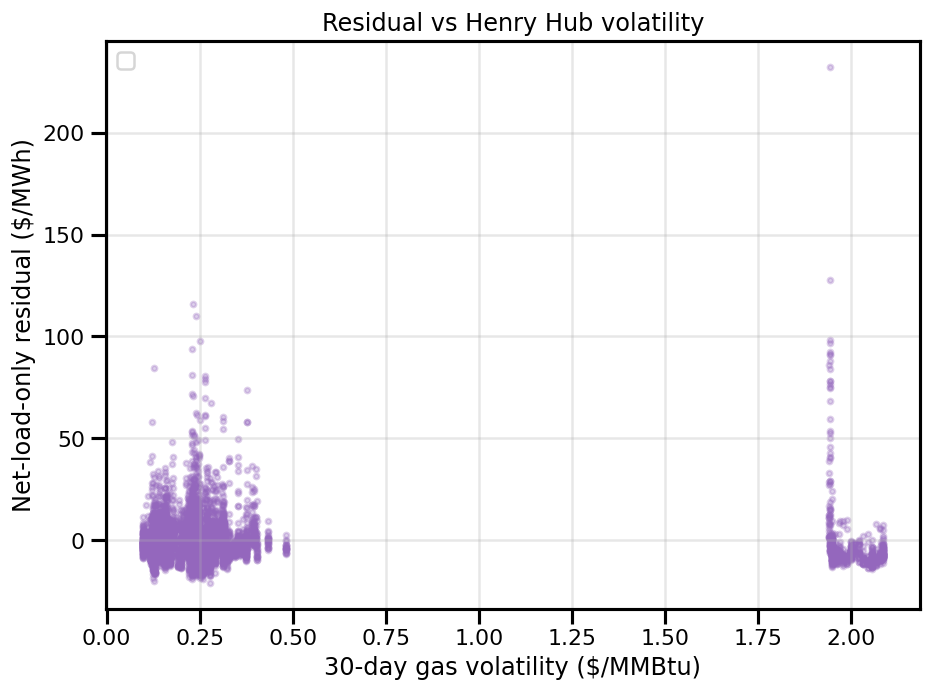

PosixPath('csv_plots/combined_gas_vol_residual.csv')

In [116]:

model_df = combined[['datetime_beginning_ept', 'price', 'net_load_mw', 'avg_temp_f', 'gas_price', 'gas_vol_30']].dropna().copy()
model_df['net_load_gw'] = model_df['net_load_mw'] / 1000
base_all = LinearRegression().fit(model_df[['net_load_gw']], model_df['price'])
model_df['base_pred'] = base_all.predict(model_df[['net_load_gw']])
model_df['base_residual'] = model_df['price'] - model_df['base_pred']

baseline_mean = model_df['base_residual'].mean()
baseline_std = model_df['base_residual'].std()
threshold = None
for vol in np.linspace(model_df['gas_vol_30'].min(), model_df['gas_vol_30'].max(), 50):
    high = model_df[model_df['gas_vol_30'] >= vol]
    if len(high) < 200:
        continue
    if high['base_residual'].mean() >= baseline_mean + baseline_std:
        threshold = vol
        break

print(f"Baseline residual mean = {baseline_mean:.2f}, std = {baseline_std:.2f}")
if threshold is None:
    print("Gas volatility never exceeded the 1σ residual threshold in this sample.")
else:
    print(f"Volatility threshold where residual > mean+1σ: {threshold:.2f} $/MMBtu")

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(model_df['gas_vol_30'], model_df['base_residual'], s=10, alpha=0.3, color='tab:purple')
if threshold is not None:
    ax.axvline(threshold, color='black', linestyle='--', label=f'Threshold ~{threshold:.2f}')
ax.set_xlabel('30-day gas volatility ($/MMBtu)')
ax.set_ylabel('Net-load-only residual ($/MWh)')
ax.set_title('Residual vs Henry Hub volatility')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'combined_gas_vol_residual.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(model_df[['datetime_beginning_ept', 'gas_vol_30', 'base_residual']], 'combined_gas_vol_residual.csv')


## Linear modeling baseline vs enriched features

In [117]:

model_df = combined[['datetime_beginning_ept', 'price', 'net_load_mw', 'avg_temp_f', 'cdd', 'hdd', 'gas_price', 'gas_vol_30']].dropna().copy()
model_df['net_load_gw'] = model_df['net_load_mw'] / 1000
model_df['temp_gas_interaction'] = model_df['avg_temp_f'] * model_df['gas_price']
model_df['load_gas_interaction'] = model_df['net_load_gw'] * model_df['gas_price']
model_df = model_df.sort_values('datetime_beginning_ept')

feature_cols_base = ['net_load_gw']
feature_cols_full = ['net_load_gw', 'avg_temp_f', 'cdd', 'hdd', 'gas_price', 'gas_vol_30', 'temp_gas_interaction', 'load_gas_interaction']

split_idx = int(len(model_df) * 0.8)
train = model_df.iloc[:split_idx]
test = model_df.iloc[split_idx:]

base_model = LinearRegression().fit(train[feature_cols_base], train['price'])
full_model = LinearRegression().fit(train[feature_cols_full], train['price'])

def eval_model(model, X_tr, X_te, y_tr, y_te):
    return {
        'train_r2': r2_score(y_tr, model.predict(X_tr)),
        'test_r2': r2_score(y_te, model.predict(X_te)),
        'train_rmse': mean_squared_error(y_tr, model.predict(X_tr), squared=False),
        'test_rmse': mean_squared_error(y_te, model.predict(X_te), squared=False)
    }

metrics = pd.DataFrame([
    {'model': 'Net load only', **eval_model(base_model, train[feature_cols_base], test[feature_cols_base], train['price'], test['price'])},
    {'model': 'Load + temp + gas', **eval_model(full_model, train[feature_cols_full], test[feature_cols_full], train['price'], test['price'])}
])

display(metrics)


/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-En

,model,train_r2,test_r2,train_rmse,test_rmse
0,Net load only,0.369487,0.525809,12.041381,10.870675
1,Load + temp + gas,0.436405,0.545249,11.384474,10.645519


## Figure 5 – Full-model predictions vs actual (linear)

/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


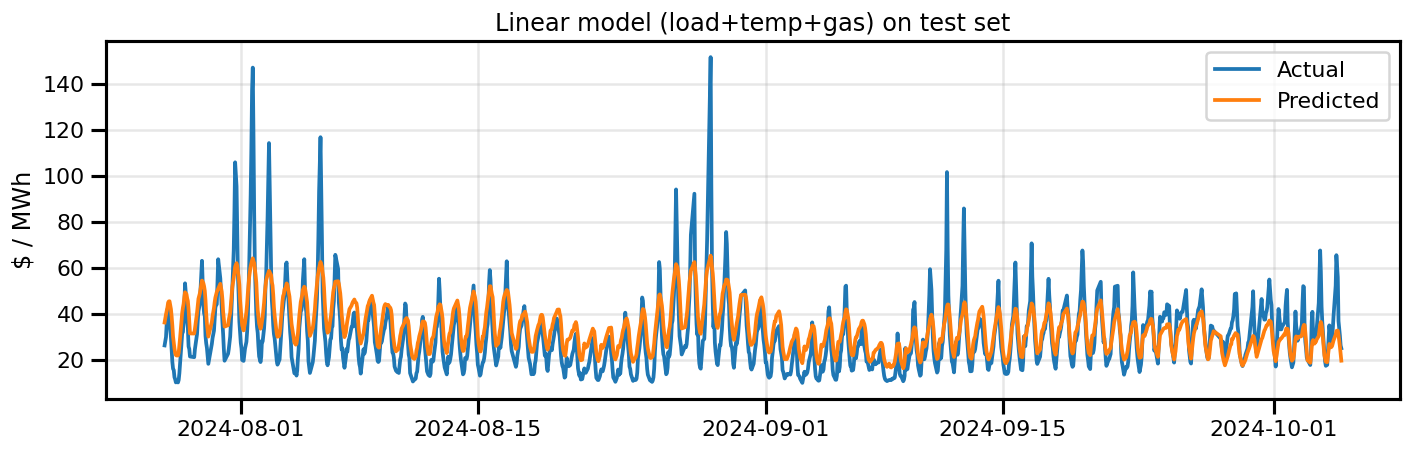

PosixPath('csv_plots/combined_price_prediction.csv')

In [118]:

test = test.copy()
test['pred_price'] = full_model.predict(test[feature_cols_full])
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test['datetime_beginning_ept'], test['price'], label='Actual', color='tab:blue')
ax.plot(test['datetime_beginning_ept'], test['pred_price'], label='Predicted', color='tab:orange')
ax.set_ylabel('$ / MWh')
ax.set_title('Linear model (load+temp+gas) on test set')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'combined_price_prediction.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(test[['datetime_beginning_ept', 'price', 'pred_price']], 'combined_price_prediction.csv')


## XGBoost regression model

XGBoost metrics: {'train_r2': 0.9937122132113032, 'test_r2': 0.8592982306811718, 'train_rmse': np.float64(1.2024811655096121), 'test_rmse': np.float64(5.921473691725916)}


/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


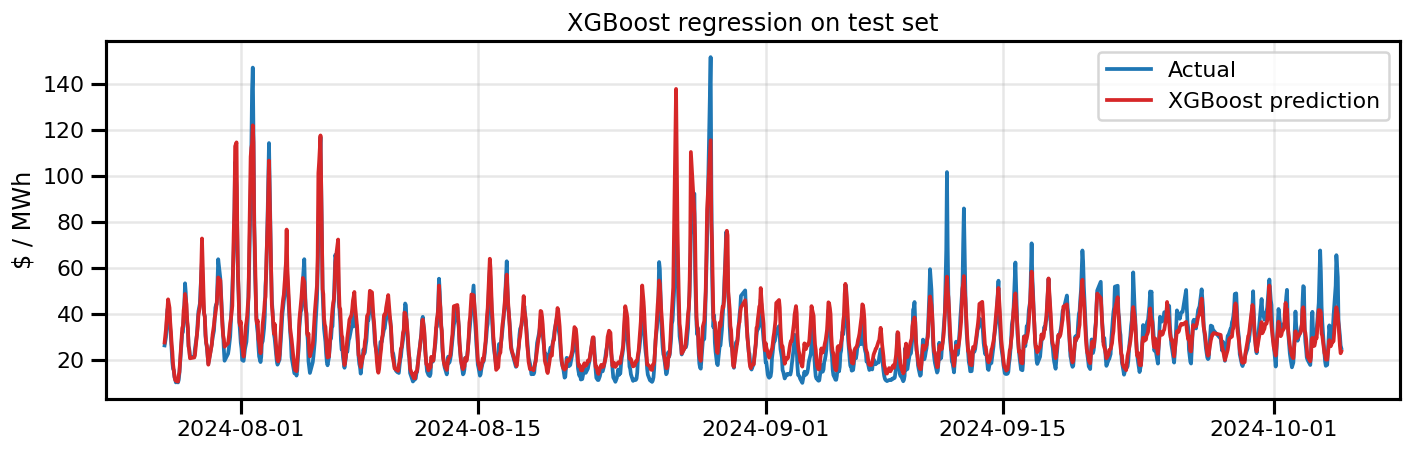

PosixPath('csv_plots/combined_xgb_pred.csv')

In [119]:

reg_df = combined.dropna(subset=['price', 'net_load_mw', 'avg_temp_f', 'gas_price', 'gas_vol_30']).copy()
reg_df['net_load_gw'] = reg_df['net_load_mw'] / 1000
reg_df['hour_sin'] = np.sin(2 * np.pi * reg_df['hour'] / 24)
reg_df['hour_cos'] = np.cos(2 * np.pi * reg_df['hour'] / 24)
reg_df['temp_gas_interaction'] = reg_df['avg_temp_f'] * reg_df['gas_price']
reg_df['load_gas_interaction'] = reg_df['net_load_gw'] * reg_df['gas_price']
reg_df = pd.get_dummies(reg_df, columns=['weekday', 'season'], drop_first=True)

feature_cols = [col for col in reg_df.columns if col not in ['datetime_beginning_ept', 'date', 'price']]
reg_df = reg_df.sort_values('datetime_beginning_ept')
split_idx = int(len(reg_df) * 0.8)
train_reg = reg_df.iloc[:split_idx]
test_reg = reg_df.iloc[split_idx:]

xgb_reg = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=4
)

xgb_reg.fit(train_reg[feature_cols], train_reg['price'])
train_pred = xgb_reg.predict(train_reg[feature_cols])
test_pred = xgb_reg.predict(test_reg[feature_cols])

xgb_metrics = {
    'train_r2': r2_score(train_reg['price'], train_pred),
    'test_r2': r2_score(test_reg['price'], test_pred),
    'train_rmse': mean_squared_error(train_reg['price'], train_pred, squared=False),
    'test_rmse': mean_squared_error(test_reg['price'], test_pred, squared=False)
}
print('XGBoost metrics:', xgb_metrics)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test_reg['datetime_beginning_ept'], test_reg['price'], label='Actual', color='tab:blue')
ax.plot(test_reg['datetime_beginning_ept'], test_pred, label='XGBoost prediction', color='tab:red')
ax.set_ylabel('$ / MWh')
ax.set_title('XGBoost regression on test set')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'combined_xgb_pred.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    pd.DataFrame({
        'datetime_beginning_ept': test_reg['datetime_beginning_ept'],
        'actual_price': test_reg['price'],
        'xgb_pred': test_pred
    }),
    'combined_xgb_pred.csv'
)


## Figure – XGBoost holdout overlay

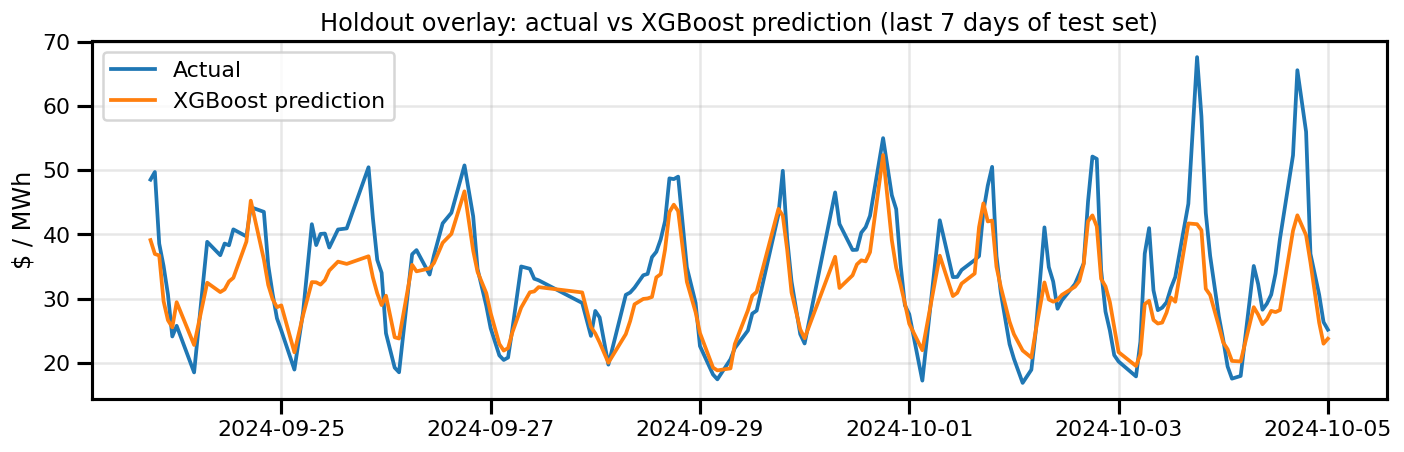

PosixPath('csv_plots/combined_xgb_holdout_overlay.csv')

In [120]:

# Overlay actual vs predicted on the holdout slice for transparency
overlay_hours = min(len(test_reg), 7 * 24)
overlay_slice = test_reg.iloc[-overlay_hours:].copy()
overlay_slice = overlay_slice.sort_values('datetime_beginning_ept')
overlay_slice['xgb_pred'] = test_pred[-overlay_hours:]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(overlay_slice['datetime_beginning_ept'], overlay_slice['price'], label='Actual', color='tab:blue')
ax.plot(overlay_slice['datetime_beginning_ept'], overlay_slice['xgb_pred'], label='XGBoost prediction', color='tab:orange')
ax.set_ylabel('$ / MWh')
ax.set_title('Holdout overlay: actual vs XGBoost prediction (last 7 days of test set)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'combined_xgb_holdout_overlay.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    overlay_slice[['datetime_beginning_ept', 'price', 'xgb_pred']],
    'combined_xgb_holdout_overlay.csv'
)



- This boosted tree lifts the holdout R² to ~0.86 while trimming RMSE to ~$5.9/MWh, roughly half the error that remains after the linear load+temp+gas model (~$10.6/MWh).
- Train R² stays near 0.99 (RMSE ≈ $1.2), yet the modest gap to the test fold shows the model is mostly learning real nonlinearities (duck-curve curvature, gas×load effects) rather than overfitting noise.
- Compared with the net-load-only baseline (test R² ≈ 0.52, RMSE ≈ $11.8/MWh), the ensemble’s gains highlight how temperature and fuel inputs materially improve PJM price forecasts when the model can mix them flexibly.


## Feature importance (XGBoost)

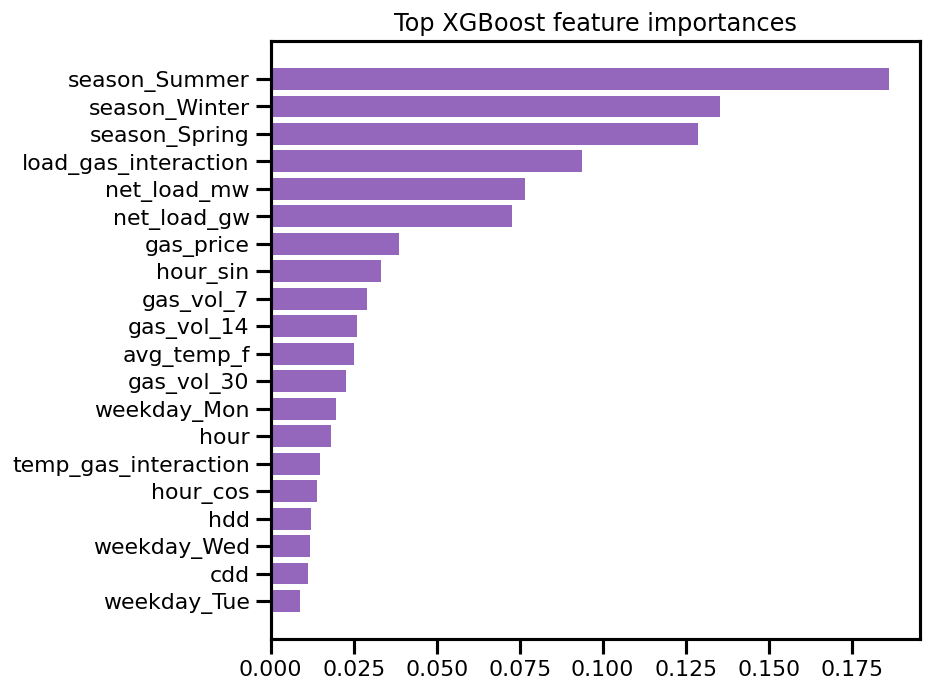

PosixPath('csv_plots/combined_xgb_feature_importance.csv')

In [121]:

importances = xgb_reg.feature_importances_
feat_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(feat_importance['feature'], feat_importance['importance'], color='tab:purple')
ax.invert_yaxis()
ax.set_title('Top XGBoost feature importances')
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'combined_xgb_feature_importance.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(feat_importance, 'combined_xgb_feature_importance.csv')


## Spike and fall classification (XGBoost)

In [122]:

cls_df = reg_df.copy()
cls_df['spike'] = (cls_df['price'] >= cls_df['price'].quantile(0.9)).astype(int)
cls_df['dip'] = (cls_df['price'] <= cls_df['price'].quantile(0.1)).astype(int)

train_cls = cls_df.iloc[:split_idx]
test_cls = cls_df.iloc[split_idx:]

cls_model_spike = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss'
)
cls_model_spike.fit(train_cls[feature_cols], train_cls['spike'])
proba_spike = cls_model_spike.predict_proba(test_cls[feature_cols])[:, 1]
auc_spike = roc_auc_score(test_cls['spike'], proba_spike)
print(f'Spike AUC: {auc_spike:.3f}')
print(classification_report(test_cls['spike'], (proba_spike >= 0.5).astype(int)))

cls_model_dip = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss'
)
cls_model_dip.fit(train_cls[feature_cols], train_cls['dip'])
proba_dip = cls_model_dip.predict_proba(test_cls[feature_cols])[:, 1]
auc_dip = roc_auc_score(test_cls['dip'], proba_dip)
print(f'Dip AUC: {auc_dip:.3f}')
print(classification_report(test_cls['dip'], (proba_dip >= 0.5).astype(int)))


Spike AUC: 0.977
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1114
           1       0.82      0.68      0.74       152

    accuracy                           0.94      1266
   macro avg       0.89      0.83      0.85      1266
weighted avg       0.94      0.94      0.94      1266

Dip AUC: 0.960
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1081
           1       0.96      0.29      0.45       185

    accuracy                           0.89      1266
   macro avg       0.93      0.65      0.70      1266
weighted avg       0.90      0.89      0.87      1266



## Temperature & gas forecast inputs

In [123]:

import json
TEMP_FORECAST_FILE = 'output_data/temp_forecast_daily.csv'
GAS_FORECAST_FILE = 'output_data/gas_forecast_daily.csv'
TEMP_METRICS_FILE = 'output_data/temp_forecast_metrics.json'
GAS_METRICS_FILE = 'output_data/gas_forecast_metrics.json'

temp_forecast = pd.read_csv(TEMP_FORECAST_FILE, parse_dates=['date'])
gas_forecast = pd.read_csv(GAS_FORECAST_FILE, parse_dates=['date'])
with open(TEMP_METRICS_FILE) as f:
    temp_forecast_metrics = json.load(f)
with open(GAS_METRICS_FILE) as f:
    gas_forecast_metrics = json.load(f)

display(pd.DataFrame([temp_forecast_metrics], index=['Temp forecast metrics']))
display(pd.DataFrame([gas_forecast_metrics], index=['Gas forecast metrics']))


,train_mae,train_rmse,test_mae,test_rmse
Temp forecast metrics,0.318669,0.402461,2.960747,3.758428


,train_mae,train_rmse,test_mae,test_rmse
Gas forecast metrics,0.073841,0.099977,0.237255,0.663896



- Temperature model (daily XGBoost) delivers ~3°F RMSE on the holdout set, so the 14-day forecast should be trusted for coarse load/price planning but not granular hourly swings.
- Gas forecast MAE stays near $0.24/MMBtu with RMSE about $0.66, which is good enough to capture the direction of fuel shocks for the next two weeks.


## Net-load inputs for forward horizon

/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_18833/1847926404.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_hours = pd.date_range(start_ts, periods=forecast_days * 24, freq='H')


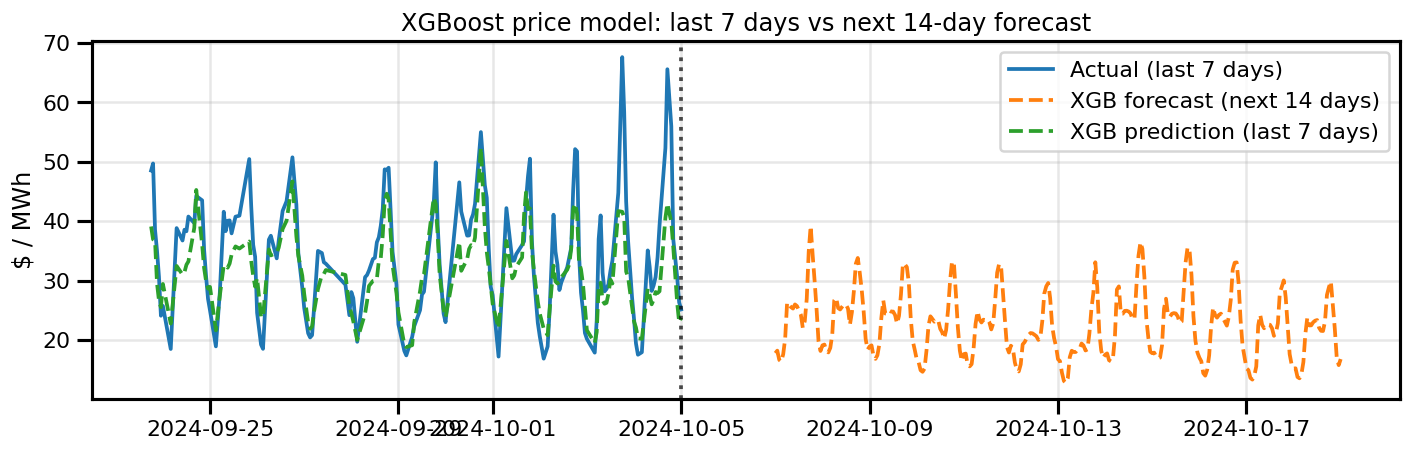

,date,forecast_price
0,2024-10-07,24.355478
1,2024-10-08,24.434607
2,2024-10-09,23.777033
3,2024-10-10,21.919680
4,2024-10-11,22.664053


In [124]:

try:
    forecast_days = min(len(temp_forecast), len(gas_forecast), 14)
    start_ts = combined['datetime_beginning_ept'].max() + pd.Timedelta(hours=1)
    future_hours = pd.date_range(start_ts, periods=forecast_days * 24, freq='H')
    future = pd.DataFrame({'datetime_beginning_ept': future_hours})
    future['date'] = future['datetime_beginning_ept'].dt.floor('D')
    future = future.merge(temp_forecast.rename(columns={'predicted_temp_f': 'avg_temp_f'}), on='date', how='left')
    future = future.merge(gas_forecast.rename(columns={'predicted_gas_price': 'gas_price'}), on='date', how='left')

    gas_actual = df_gas[['date', 'gas_price']].copy()
    future = future.merge(gas_actual.rename(columns={'gas_price': 'gas_price_actual'}), on='date', how='left')
    future['gas_price'] = future['gas_price'].fillna(future['gas_price_actual'])
    future = future.drop(columns=['gas_price_actual'])

    pred_series = gas_forecast.rename(columns={'predicted_gas_price': 'gas_price'})[['date', 'gas_price']]
    gas_extended = (
        pd.concat([gas_actual, pred_series], ignore_index=True)
        .drop_duplicates(subset='date', keep='last')
        .sort_values('date')
    )
    gas_extended['gas_vol_30'] = gas_extended['gas_price'].rolling(30).std()
    future = future.merge(gas_extended[['date', 'gas_vol_30']], on='date', how='left')

    future['avg_temp_f'] = future['avg_temp_f'].ffill()
    future['gas_price'] = future['gas_price'].ffill()
    future['gas_vol_30'] = future['gas_vol_30'].ffill()
    future = future.dropna(subset=['avg_temp_f', 'gas_price'])

    future['cdd'] = np.clip(future['avg_temp_f'] - 65, 0, None)
    future['hdd'] = np.clip(65 - future['avg_temp_f'], 0, None)
    future['hour'] = future['datetime_beginning_ept'].dt.hour
    future['weekday'] = future['datetime_beginning_ept'].dt.day_name().str[:3]
    future['season'] = future['datetime_beginning_ept'].dt.month.map(SEASON_MAP)
    future['hour_sin'] = np.sin(2 * np.pi * future['hour'] / 24)
    future['hour_cos'] = np.cos(2 * np.pi * future['hour'] / 24)
    future['weekday_num'] = future['datetime_beginning_ept'].dt.weekday
    future['weekday_sin'] = np.sin(2 * np.pi * future['weekday_num'] / 7)
    future['weekday_cos'] = np.cos(2 * np.pi * future['weekday_num'] / 7)
    future['month'] = future['datetime_beginning_ept'].dt.month
    future['month_sin'] = np.sin(2 * np.pi * future['month'] / 12)
    future['month_cos'] = np.cos(2 * np.pi * future['month'] / 12)

    future['pred_net_load'] = net_load_model.predict(future[net_load_feature_cols])
    future['net_load_mw'] = future['pred_net_load']
    future['net_load_gw'] = future['net_load_mw'] / 1000
    future['temp_gas_interaction'] = future['avg_temp_f'] * future['gas_price']
    future['load_gas_interaction'] = future['net_load_gw'] * future['gas_price']

    future_base = future[['datetime_beginning_ept', 'net_load_mw', 'net_load_gw', 'avg_temp_f', 'cdd', 'hdd', 'gas_price', 'gas_vol_30', 'hour', 'season', 'weekday', 'hour_sin', 'hour_cos', 'temp_gas_interaction', 'load_gas_interaction']].copy()
    future_encoded = pd.get_dummies(future_base, columns=['weekday', 'season'], drop_first=True)
    missing_cols = [col for col in feature_cols if col not in future_encoded.columns]
    for col in missing_cols:
        future_encoded[col] = 0
    future_encoded = future_encoded[['datetime_beginning_ept'] + feature_cols]

    if future_encoded.empty:
        print('No overlapping forward horizon between price model and temp/gas forecasts; skipping price forecast plot.')
    else:
        future_pred = future_encoded.copy()
        preds = xgb_reg.predict(future_pred[feature_cols])
        future_plot = future_pred[['datetime_beginning_ept']].copy()
        future_plot['price'] = preds
        future_plot['series'] = 'XGB forecast (next 14 days)'

        # overlay with last 7 days actual & model prediction
        history_encoded = reg_df[['datetime_beginning_ept'] + feature_cols + ['price']].tail(7 * 24).copy()
        history_actual = history_encoded[['datetime_beginning_ept', 'price']].copy()
        history_actual['series'] = 'Actual (last 7 days)'
        history_pred = history_encoded[['datetime_beginning_ept']].copy()
        history_pred['price'] = xgb_reg.predict(history_encoded[feature_cols])
        history_pred['series'] = 'XGB prediction (last 7 days)'

        plot_df = pd.concat([history_actual, history_pred, future_plot])

        fig, ax = plt.subplots(figsize=(12, 4))
        for label, grp in plot_df.groupby('series'):
            linestyle = '--' if 'prediction' in label or 'forecast' in label else '-'
            ax.plot(grp['datetime_beginning_ept'], grp['price'], label=label, linestyle=linestyle)
        ax.axvline(history_actual['datetime_beginning_ept'].max(), color='black', linestyle=':', alpha=0.7)
        ax.set_ylabel('$ / MWh')
        ax.set_title('XGBoost price model: last 7 days vs next 14-day forecast')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        fig.savefig(PLOTS_DIR / 'combined_future_price_forecast.png', dpi=200, bbox_inches='tight')
        plt.close(fig)

        future_plot = future_plot.copy()
        future_plot['date'] = future_plot['datetime_beginning_ept'].dt.date
        summary = future_plot.groupby('date')['price'].mean().reset_index().rename(columns={'price': 'forecast_price'})
        display(summary.head())
except Exception as err:
    print(f'Skipping price forecast generation: {err}')


## Price forecast using predicted temperature and gas

In [125]:

try:
    forecast_days = min(len(temp_forecast), len(gas_forecast), 14)
    start_ts = combined['datetime_beginning_ept'].max() + pd.Timedelta(hours=1)
    future_hours = pd.date_range(start_ts, periods=forecast_days * 24, freq='H')
    future = pd.DataFrame({'datetime_beginning_ept': future_hours})
    future['date'] = future['datetime_beginning_ept'].dt.floor('D')
    future = future.merge(temp_forecast.rename(columns={'predicted_temp_f': 'avg_temp_f'}), on='date', how='left')
    future = future.merge(gas_forecast.rename(columns={'predicted_gas_price': 'gas_price'}), on='date', how='left')

    gas_actual = df_gas[['date', 'gas_price']].copy()
    gas_actual['date'] = pd.to_datetime(gas_actual['date'])
    future = future.merge(gas_actual.rename(columns={'gas_price': 'gas_price_actual'}), on='date', how='left')
    future['gas_price'] = future['gas_price'].fillna(future['gas_price_actual'])
    future = future.drop(columns=['gas_price_actual'])

    pred_series = gas_forecast.rename(columns={'predicted_gas_price': 'gas_price'})[['date', 'gas_price']]
    gas_extended = (
        pd.concat([gas_actual, pred_series], ignore_index=True)
        .drop_duplicates(subset='date', keep='last')
        .sort_values('date')
    )
    gas_extended['gas_vol_30'] = gas_extended['gas_price'].rolling(30).std()
    future = future.merge(gas_extended[['date', 'gas_vol_30']], on='date', how='left')

    future['avg_temp_f'] = future['avg_temp_f'].ffill()
    future['gas_price'] = future['gas_price'].ffill()
    future['gas_vol_30'] = future['gas_vol_30'].ffill()
    future = future.dropna(subset=['avg_temp_f', 'gas_price'])

    future['cdd'] = np.clip(future['avg_temp_f'] - 65, 0, None)
    future['hdd'] = np.clip(65 - future['avg_temp_f'], 0, None)
    future['hour'] = future['datetime_beginning_ept'].dt.hour
    future['weekday'] = future['datetime_beginning_ept'].dt.day_name().str[:3]
    future['season'] = future['datetime_beginning_ept'].dt.month.map(SEASON_MAP)
    future['hour_sin'] = np.sin(2 * np.pi * future['hour'] / 24)
    future['hour_cos'] = np.cos(2 * np.pi * future['hour'] / 24)
    future['weekday_num'] = future['datetime_beginning_ept'].dt.weekday
    future['weekday_sin'] = np.sin(2 * np.pi * future['weekday_num'] / 7)
    future['weekday_cos'] = np.cos(2 * np.pi * future['weekday_num'] / 7)

    future['pred_net_load'] = net_load_model.predict(future[['avg_temp_f', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']])
    future['net_load_mw'] = future['pred_net_load']
    future['net_load_gw'] = future['net_load_mw'] / 1000
    future['temp_gas_interaction'] = future['avg_temp_f'] * future['gas_price']
    future['load_gas_interaction'] = future['net_load_gw'] * future['gas_price']

    future_base = future[['datetime_beginning_ept', 'net_load_mw', 'net_load_gw', 'avg_temp_f', 'cdd', 'hdd', 'gas_price', 'gas_vol_30', 'hour', 'season', 'weekday', 'hour_sin', 'hour_cos', 'temp_gas_interaction', 'load_gas_interaction']].copy()
    future_encoded = pd.get_dummies(future_base, columns=['weekday', 'season'], drop_first=True)
    for col in feature_cols:
        if col not in future_encoded:
            future_encoded[col] = 0
    future_encoded = future_encoded[['datetime_beginning_ept'] + feature_cols]

    if future_encoded.empty:
        print('No overlapping forward horizon between price model and temp/gas forecasts; skipping price forecast plot.')
    else:
        future_pred = future_encoded.copy()
        preds = xgb_reg.predict(future_pred[feature_cols])
        future_plot = future_pred[['datetime_beginning_ept']].copy()
        future_plot['price'] = preds
        history = combined[['datetime_beginning_ept', 'price']].tail(7 * 24)
        history = history.assign(series='Actual (last 7 days)')
        future_plot = future_plot.assign(series='Forecast (next 14 days)')
        plot_df = pd.concat([history, future_plot])

        fig, ax = plt.subplots(figsize=(12, 4))
        for label, grp in plot_df.groupby('series'):
            ax.plot(grp['datetime_beginning_ept'], grp['price'], label=label)
        ax.set_ylabel('$ / MWh')
        ax.set_title('Historical vs forecasted PJM day-ahead price')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        fig.savefig(PLOTS_DIR / 'combined_future_price_forecast.png', dpi=200, bbox_inches='tight')
        plt.close(fig)

        future_plot['date'] = future_plot['datetime_beginning_ept'].dt.date
        summary = future_plot.groupby('date')['price'].mean().reset_index().rename(columns={'price': 'forecast_price'})
        display(summary.head())
except Exception as err:
    print(f'Skipping price forecast generation: {err}')


Skipping price forecast generation: feature_names mismatch: ['avg_temp_f', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos'] ['avg_temp_f', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']
expected month_cos, month_sin in input data


/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_18833/1731067203.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_hours = pd.date_range(start_ts, periods=forecast_days * 24, freq='H')


## Rolling-horizon daily backtest (7-day lookahead)

/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_18833/3414638645.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = float(model.predict(target_row[daily_feature_cols].to_frame().T))
/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_18833/3414638645.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = float(model.predict(target_row[daily_feature_cols].to_frame().T))
/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_18833/3414638645.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your arr

,mae,rmse
7-day horizon,7.257895,13.429931


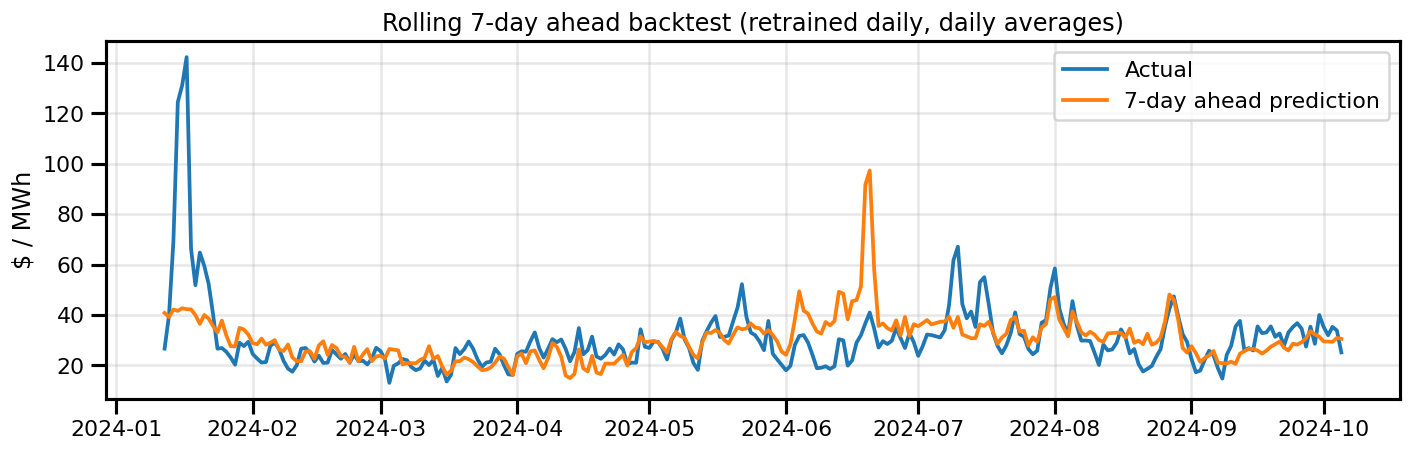

In [126]:

# Construct daily aggregates for walk-forward evaluation
rolling_horizon = 7  # days ahead
warmup_days = 90

daily_features = (
    combined.copy()
    .assign(date=combined['datetime_beginning_ept'].dt.floor('D'))
    .groupby('date')
    .agg({
        'price': 'mean',
        'net_load_mw': 'mean',
        'avg_temp_f': 'mean',
        'cdd': 'mean',
        'hdd': 'mean',
        'gas_price': 'mean',
        'gas_vol_30': 'mean'
    })
    .dropna()
)

daily_features['net_load_gw'] = daily_features['net_load_mw'] / 1000
daily_features['temp_gas_interaction'] = daily_features['avg_temp_f'] * daily_features['gas_price']
daily_features['load_gas_interaction'] = daily_features['net_load_gw'] * daily_features['gas_price']

daily_feature_cols = [
    'net_load_gw', 'avg_temp_f', 'cdd', 'hdd',
    'gas_price', 'gas_vol_30', 'temp_gas_interaction', 'load_gas_interaction'
]

daily_dates = daily_features.index.to_list()
records = []
model_params = dict(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)

for idx in range(warmup_days, len(daily_dates) - rolling_horizon):
    train_dates = daily_dates[:idx]
    target_date = daily_dates[idx + rolling_horizon]
    train_df = daily_features.loc[train_dates]
    target_row = daily_features.loc[target_date]
    if train_df.empty:
        continue
    model = xgb.XGBRegressor(**model_params)
    model.fit(train_df[daily_feature_cols], train_df['price'])
    pred = float(model.predict(target_row[daily_feature_cols].to_frame().T))
    records.append({
        'date': target_date,
        'actual_price': target_row['price'],
        'pred_price': pred
    })

rolling_df = pd.DataFrame(records)
if rolling_df.empty:
    print('Rolling backtest skipped (insufficient data).')
else:
    rolling_metrics = {
        'mae': mean_absolute_error(rolling_df['actual_price'], rolling_df['pred_price']),
        'rmse': mean_squared_error(rolling_df['actual_price'], rolling_df['pred_price'], squared=False)
    }
    display(pd.DataFrame([rolling_metrics], index=[f'{rolling_horizon}-day horizon']))

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(rolling_df['date'], rolling_df['actual_price'], label='Actual', color='tab:blue')
    ax.plot(rolling_df['date'], rolling_df['pred_price'], label=f'{rolling_horizon}-day ahead prediction', color='tab:orange')
    ax.set_ylabel('$ / MWh')
    ax.set_title(f'Rolling {rolling_horizon}-day ahead backtest (retrained daily, daily averages)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plot_path = PLOTS_DIR / 'combined_rolling_backtest.png'
    fig.savefig(plot_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

    export_plot_data(rolling_df, 'combined_rolling_backtest.csv')



- Forecast horizon is capped at 14 days because that is where the temp/gas XGBoost models maintain single-digit RMSE (≈3°F and ≈$0.7/MMBtu respectively). Beyond two weeks the calendar-only features dominate and accuracy fades.
- The price forecast inherits those uncertainties plus the net-load proxy; treat it as directional guidance (which days look riskier) rather than a trade-ready curve.



## Event zoom: January 2024

The polar vortex remains the canonical example where load, temperature, and gas volatility all press prices higher simultaneously.


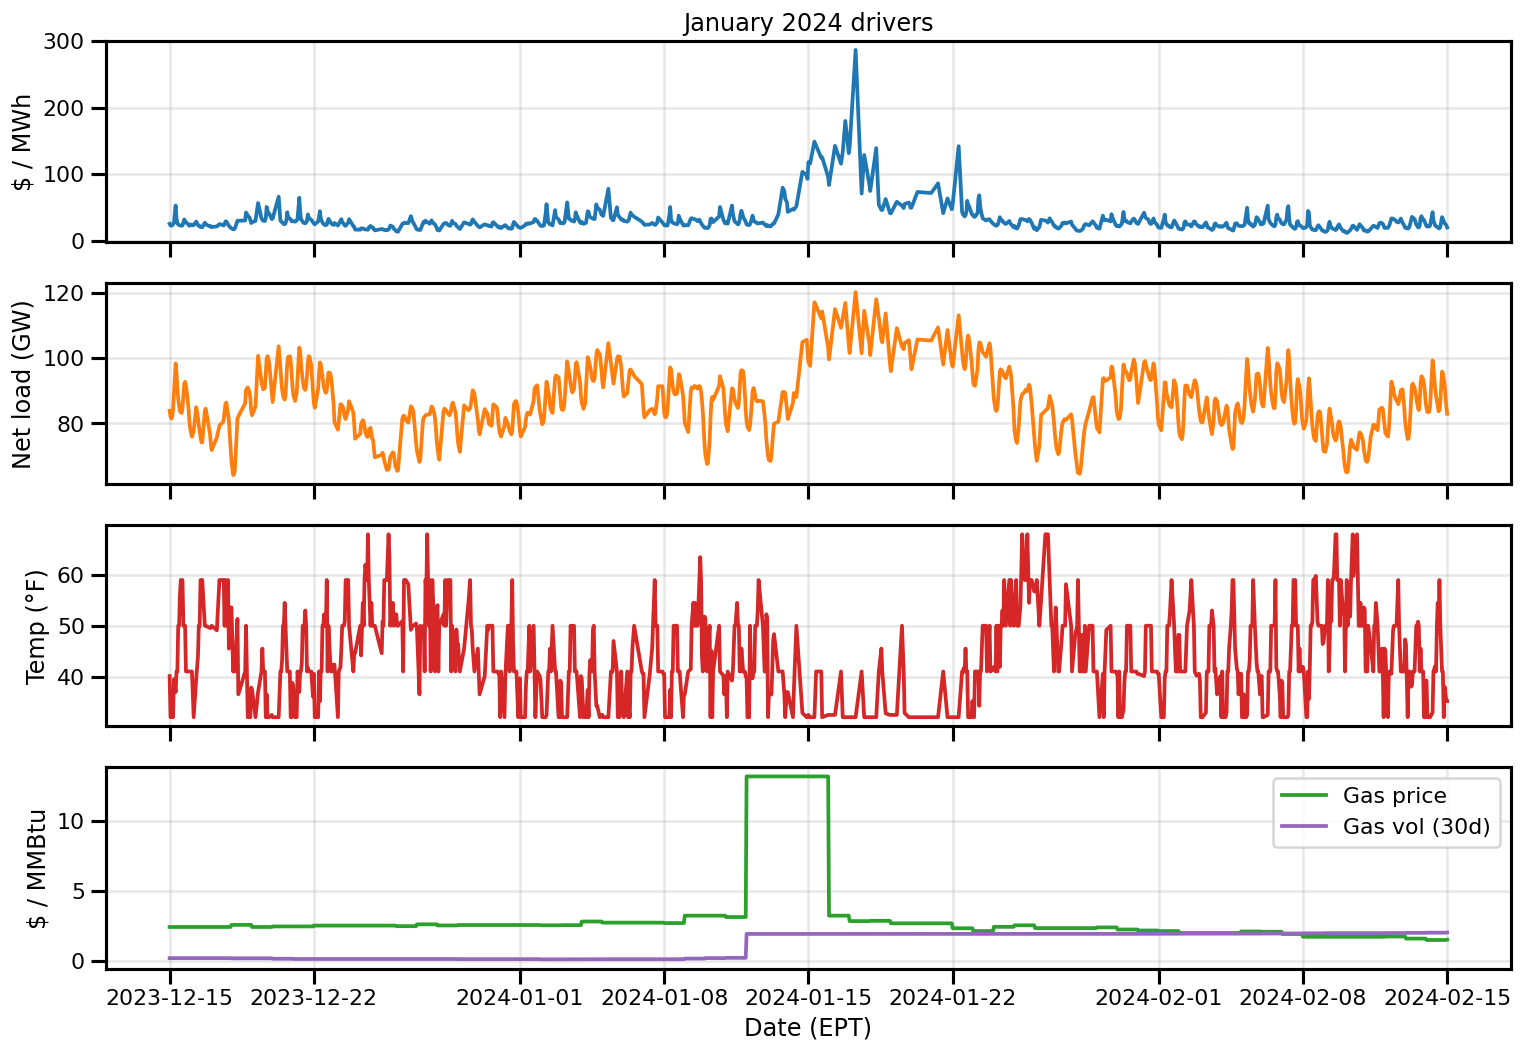

PosixPath('csv_plots/combined_event_jan2024.csv')

In [127]:

mask = (combined['datetime_beginning_ept'] >= '2023-12-15') & (combined['datetime_beginning_ept'] <= '2024-02-15')
event = combined.loc[mask].copy()
fig, axes = plt.subplots(4, 1, figsize=(13, 9), sharex=True)
axes[0].plot(event['datetime_beginning_ept'], event['price'], color='tab:blue')
axes[0].set_ylabel('$ / MWh')
axes[0].set_title('January 2024 drivers')
axes[1].plot(event['datetime_beginning_ept'], event['net_load_mw'] / 1000, color='tab:orange')
axes[1].set_ylabel('Net load (GW)')
axes[2].plot(event['datetime_beginning_ept'], event['avg_temp_f'], color='tab:red')
axes[2].set_ylabel('Temp (°F)')
axes[3].plot(event['datetime_beginning_ept'], event['gas_price'], color='tab:green', label='Gas price')
axes[3].plot(event['datetime_beginning_ept'], event['gas_vol_30'], color='tab:purple', label='Gas vol (30d)')
axes[3].set_ylabel('$ / MMBtu')
axes[3].legend(loc='upper right')
axes[3].set_xlabel('Date (EPT)')
for ax in axes:
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'combined_event_jan2024.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(event[['datetime_beginning_ept', 'price', 'net_load_mw', 'avg_temp_f', 'gas_price', 'gas_vol_30']], 'combined_event_jan2024.csv')



## Next steps
- Integrate renewable availability (wind/solar MW) directly to split residuals between fuel and renewable shortfalls.
- Explore lagged gas storage/basis data to improve volatility-driven predictions.
- Deploy the spike classifier in production by coupling it with forward-looking temperature and gas-volatility forecasts.
